In [1]:
import pyprob
from pyprob import Model, util
from pyprob.distributions import Categorical, Normal

import torch
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define model

First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

In similar spirit to the `torch.nn.Module`, we implement a class constructor called `__init__` and a method called `forward` that represents a single execution of the model's stochastic generative process. In other words, the `forward` method implements a joint distribution over latent and observed variables, which can be used in various ways. During forward sampling from the model, `forward` represents the model prior; during inference, `forward` is used by one of the available probabilistic inference engines to construct a posterior distribution given some observed variables. 

It is expected that `forward` has an argument called `observation` with which any observed variables are supplied. In addition to this, the `forward` method can have any number and type of other arguments as needed.

In [3]:
# Probabilistic program example adapted from
# http://www.robots.ox.ac.uk/~fwood/assets/pdf/Wood-AISTATS-2014.pdf
class HiddenMarkovModel(Model):
    def __init__(self, init_dist, trans_dists, obs_dists):
        self.init_dist = init_dist
        self.trans_dists = trans_dists
        self.obs_dists = obs_dists
        super().__init__('Hidden Markov model')

    def forward(self, observation=[]):
        states = [pyprob.sample(init_dist)]
        for o in observation:
            state = pyprob.sample(self.trans_dists[int(states[-1])])
            pyprob.observe(self.obs_dists[int(state)], o)
            states.append(state)
        return torch.stack([util.one_hot(3, int(s)) for s in states])

init_dist = Categorical([1, 1, 1])

trans_dists = [Categorical([0.1, 0.5, 0.4]),
               Categorical([0.2, 0.2, 0.6]),
               Categorical([0.15, 0.15, 0.7])]

obs_dists = [Normal(-1, 1),
             Normal(1, 1),
             Normal(0, 1)]

model = HiddenMarkovModel(init_dist, trans_dists, obs_dists)

# The prior

We inspect the prior distribution to see if it behaves in the way we intended. First we construct an `Empirical` distribution with forward samples from the model. 

Note: Any arguments, besides `num_traces`, given to `prior_distribution` will be forwarded to the model's `forward` function.

In [4]:
observation = [0.9, 0.8, 0.7, 0.0, -0.025, -5.0, -2.0, -0.1, 0.0, 0.13, 0.45, 6, 0.2, 0.3, -1, -1]
posterior_mean_correct = util.to_variable([[0.3775, 0.3092, 0.3133],
                                           [0.0416, 0.4045, 0.5539],
                                           [0.0541, 0.2552, 0.6907],
                                           [0.0455, 0.2301, 0.7244],
                                           [0.1062, 0.1217, 0.7721],
                                           [0.0714, 0.1732, 0.7554],
                                           [0.9300, 0.0001, 0.0699],
                                           [0.4577, 0.0452, 0.4971],
                                           [0.0926, 0.2169, 0.6905],
                                           [0.1014, 0.1359, 0.7626],
                                           [0.0985, 0.1575, 0.7440],
                                           [0.1781, 0.2198, 0.6022],
                                           [0.0000, 0.9848, 0.0152],
                                           [0.1130, 0.1674, 0.7195],
                                           [0.0557, 0.1848, 0.7595],
                                           [0.2017, 0.0472, 0.7511],
                                           [0.2545, 0.0611, 0.6844]])
        
prior_dist = model.prior_distribution(num_traces=1000, observation=observation)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 2,497.89       


We can see the mean of these samples that are held by the `Empirical` distribution.

In [5]:
prior_dist.mean

tensor([[ 0.3510,  0.3270,  0.3220],
        [ 0.1240,  0.3000,  0.5760],
        [ 0.1580,  0.2060,  0.6360],
        [ 0.1670,  0.2080,  0.6250],
        [ 0.1430,  0.2330,  0.6240],
        [ 0.1420,  0.2220,  0.6360],
        [ 0.1780,  0.2170,  0.6050],
        [ 0.1440,  0.2230,  0.6330],
        [ 0.1440,  0.2230,  0.6330],
        [ 0.1370,  0.2220,  0.6410],
        [ 0.1330,  0.2100,  0.6570],
        [ 0.1570,  0.1890,  0.6540],
        [ 0.1300,  0.2340,  0.6360],
        [ 0.1580,  0.1950,  0.6470],
        [ 0.1410,  0.2210,  0.6380],
        [ 0.1400,  0.2070,  0.6530],
        [ 0.1240,  0.2190,  0.6570]])

We can also `sample` from the `Empirical` distribution.

In [6]:
print(prior_dist.sample())

tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.]])


# Posterior inference with importance sampling

For a given set of observations, we can get samples from the posterior distribution.

In [7]:
posterior_dist = model.posterior_distribution(num_traces=400, observation=observation)

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 400/400 | 408.54       


In [8]:
posterior_dist.mean

tensor([[ 5.0996e-01,  2.0562e-01,  2.8442e-01],
        [ 6.3118e-03,  5.9756e-01,  3.9613e-01],
        [ 7.3216e-03,  7.1979e-01,  2.7289e-01],
        [ 5.5115e-03,  3.5917e-01,  6.3532e-01],
        [ 1.2430e-02,  5.5659e-01,  4.3098e-01],
        [ 4.3989e-01,  7.4124e-03,  5.5270e-01],
        [ 9.0971e-01,  5.6263e-05,  9.0238e-02],
        [ 3.9982e-01,  7.5839e-02,  5.2434e-01],
        [ 2.6058e-01,  1.3315e-01,  6.0627e-01],
        [ 3.7526e-02,  1.9235e-02,  9.4324e-01],
        [ 2.7658e-02,  2.2898e-02,  9.4945e-01],
        [ 1.0471e-01,  4.9969e-01,  3.9560e-01],
        [ 5.1085e-06,  9.8204e-01,  1.7954e-02],
        [ 7.6033e-03,  3.3286e-02,  9.5911e-01],
        [ 4.5215e-01,  9.3472e-03,  5.3850e-01],
        [ 3.0296e-02,  3.6540e-01,  6.0430e-01],
        [ 8.0138e-02,  1.1195e-02,  9.0867e-01]])

In [9]:
l2_distance = float(F.pairwise_distance(posterior_dist.mean, posterior_mean_correct).sum())
print(l2_distance)

4.827559947967529


Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1/1 | 970.45       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 101/101 | 412.25       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 201/201 | 452.80       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 301/301 | 418.28       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 401/401 | 435.41       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 501/501 | 389.62       
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 6

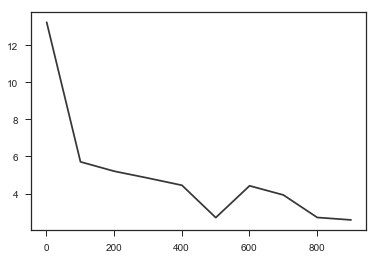

In [11]:
samples = []
l2_distances = []
for s in range(1, 1000, 100):
    posterior_dist = model.posterior_distribution(num_traces=s, observation=observation)
    l2_distance = float(F.pairwise_distance(posterior_dist.mean, posterior_mean_correct).sum())
    samples.append(s)
    l2_distances.append(l2_distance)
    
plt.plot(samples, l2_distances)
plt.show()